# Проект: классификация

**Бизнес-задача**: определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

**Техническая задача для вас как для специалиста в Data Science**: построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [4]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

Данные о клиентах банка:

* `age` (возраст);
* `job` (сфера занятости);
* `marital` (семейное положение);
* `education` (уровень образования);
* `default` (имеется ли просроченный кредит);
* `housing` (имеется ли кредит на жильё);
* `loan` (имеется ли кредит на личные нужды);
* `balance` (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

* `contact` (тип контакта с клиентом);
* `month` (месяц, в котором был последний контакт);
* `day` (день, в который был последний контакт);
* `duration` (продолжительность контакта в секундах).

Прочие признаки:

* `campaign` (количество контактов с этим клиентом в течение текущей кампании);
* `pdays` (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* `previous` (количество контактов до текущей кампании)
* `poutcome` (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная `deposit`, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [6]:
df.sample(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
5004,42,management,married,tertiary,no,"2 187,00 $",yes,no,cellular,17,nov,525,3,-1,0,unknown,yes
3443,43,technician,single,unknown,no,"11 115,00 $",no,no,cellular,23,apr,291,1,182,3,success,yes
9716,34,admin.,married,secondary,no,"560,00 $",yes,no,unknown,5,may,198,3,-1,0,unknown,no


### Задание 2

In [7]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df.job.value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [8]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

def replacing(row):
    row = row.str.replace(' ', '')
    row = row.str.replace(',00', '')
    row = row.str.replace('$', '')
    row = pd.to_numeric(row).astype(float)
    return row

df.balance = replacing(df.balance)
df.balance.describe()

count    11137.000000
mean      1529.129029
std       3228.114892
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1708.000000
max      81204.000000
Name: balance, dtype: float64

In [9]:
df.balance.mean().round(3)

1529.129

### Задание 4

In [10]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df.loc[(df['balance'].isnull()==True),'balance']=df['balance'].median()
df.balance.mean().round(3)

1526.936

### Задание 5

In [11]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
top_job = df.job.value_counts().index[0]
df.job = df.job.apply(lambda x: top_job if x == 'unknown' else x)

top_ed = df.education.value_counts().index[0]
df.education = df.education.apply(lambda x: top_ed if x == 'unknown' else x)

mask = (df.education == top_ed) & (df.job == top_job)
df[mask].balance.mean().round(3)

1598.883

### Задание 6

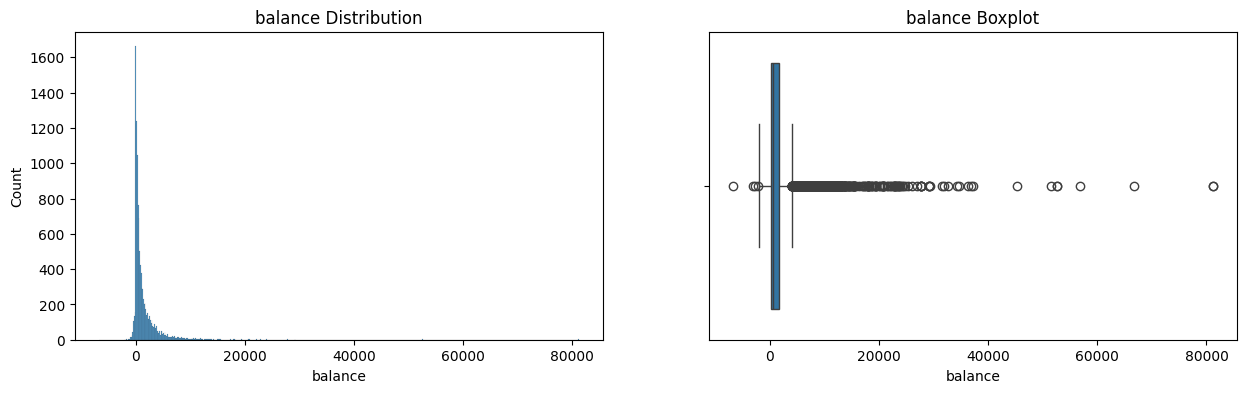

In [12]:
# удалите все выбросы для признака balance
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('balance Distribution');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('balance Boxplot');

In [13]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned, lower_bound, upper_bound = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print(f'Нижняя граница: {lower_bound}')
print(f'Верхняя граница: {upper_bound}')

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
Нижняя граница: -2241.0
Верхняя граница: 4063.0


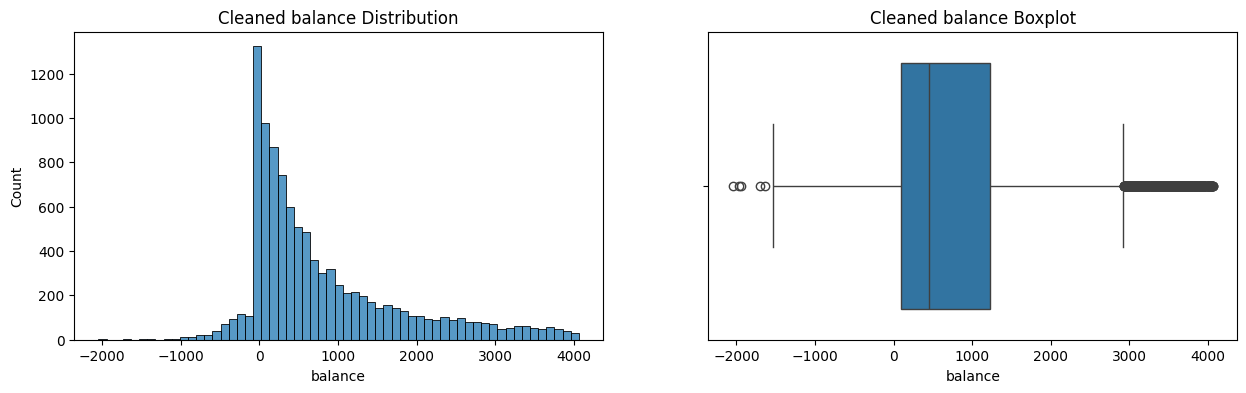

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='balance', ax=axes[0]);
histplot.set_title('Cleaned balance Distribution');
boxplot = sns.boxplot(data=cleaned, x='balance', ax=axes[1]);
boxplot.set_title('Cleaned balance Boxplot');

## Часть 2:  Разведывательный анализ

### Задание 1

In [15]:
# Для удобства переобозначим целевой признак
cleaned['deposit'] = cleaned['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

In [16]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
cleaned.deposit.value_counts()

deposit
0    5424
1    4681
Name: count, dtype: int64

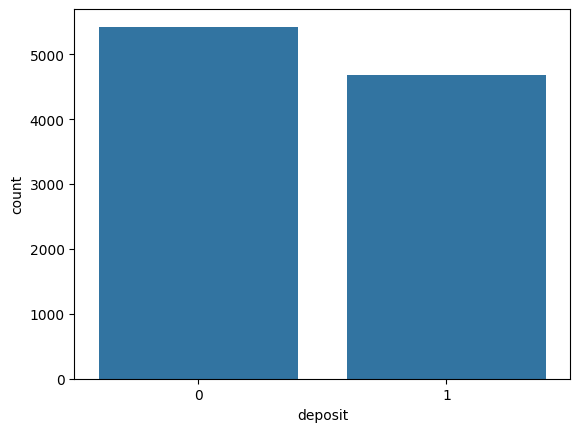

In [17]:
sns.countplot(data=cleaned, x='deposit');

### Задания 2 и 3

In [18]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
types = cleaned.dtypes
num_features = list(types[(types == 'int64')].index)+list(types[(types == 'float64')].index)
num_features.remove('deposit')
print(num_features)

['age', 'day', 'duration', 'campaign', 'pdays', 'previous', 'balance']


In [19]:
cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous,deposit
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230,0.463236
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795,0.498671
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000,1.000000


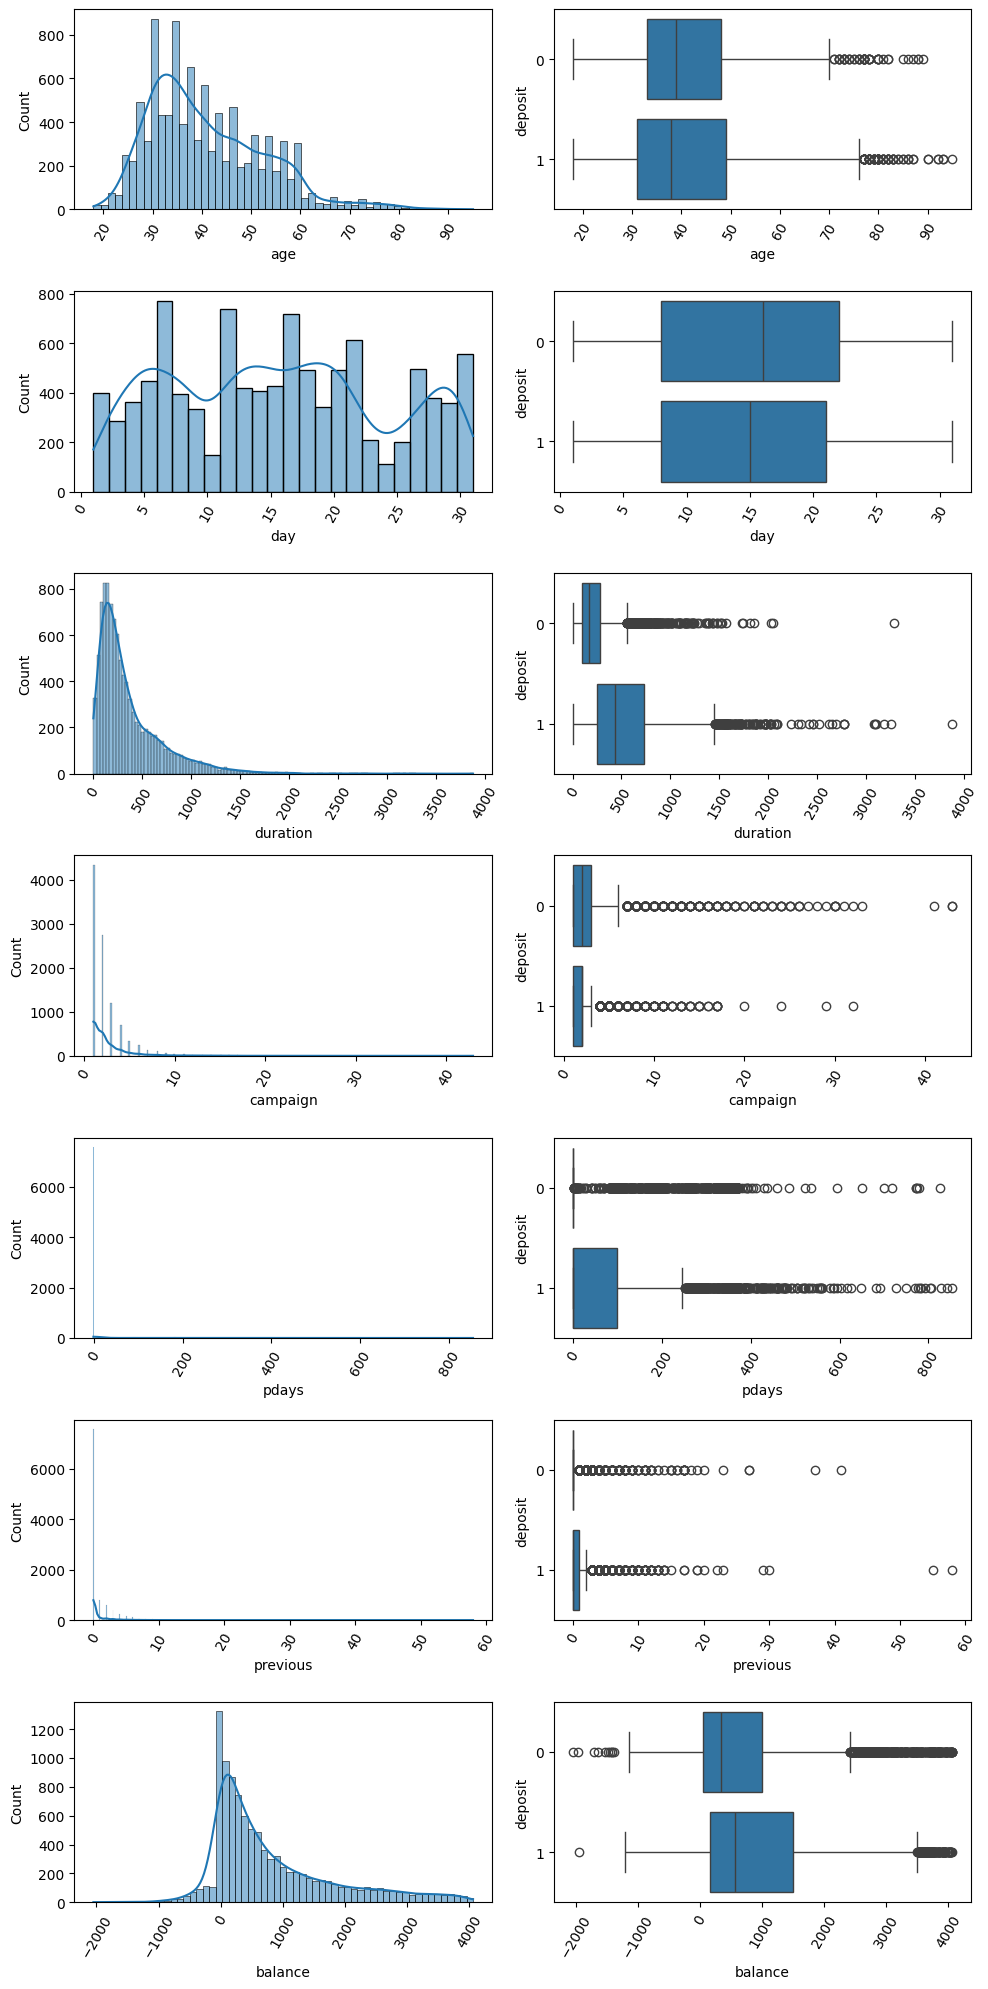

In [20]:
n = len(num_features) #число числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(10, 20)) #фигура+n*2 координатных плоскостей
#Создаём цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features):
    #Строим гистограмму каждой из категорий в данных
    hist = sns.histplot(data=cleaned, x=feature, kde=True, ax=axes[i][0])
    hist.xaxis.set_tick_params(rotation=60)
    #Посмотрим распределения в зависимости от целевой переменной
    box = sns.boxplot(data=cleaned, x=feature, y='deposit', orient='h', ax=axes[i][1])
    box.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

### Задания 4 и 5

In [26]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#постройте визуализации, иллюстрирующие результаты
types = cleaned.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [27]:
cleaned.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome
count,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4
top,management,married,secondary,no,no,no,cellular,may,unknown
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570


ValueError: Could not interpret value `index` for `x`. An entry with this name does not appear in `data`.

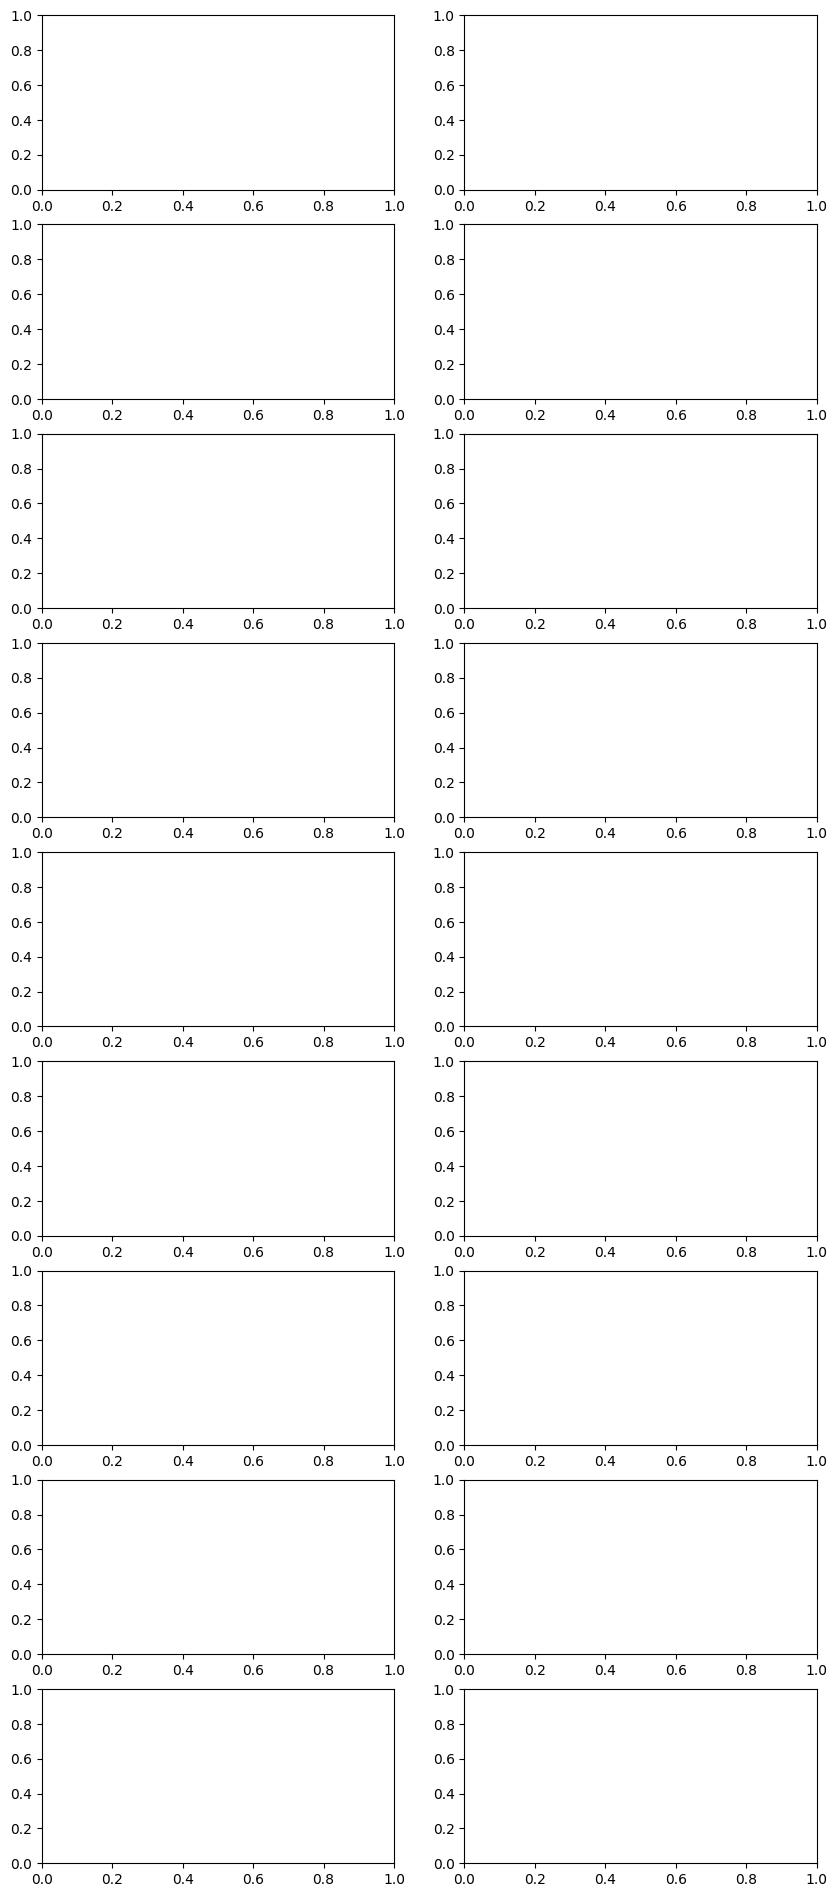

In [28]:
n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(10, 24)) #фигура+n*2 координатных плоскостей
#Создаём цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую диаграмму для долевого соотношения каждой из категорий в данных
    count_data = (cleaned[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей открывших депозит в зависимости от категории
    mean_barplot = sns.barplot(data=cleaned, x=feature, y='deposit', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

### Задание 6

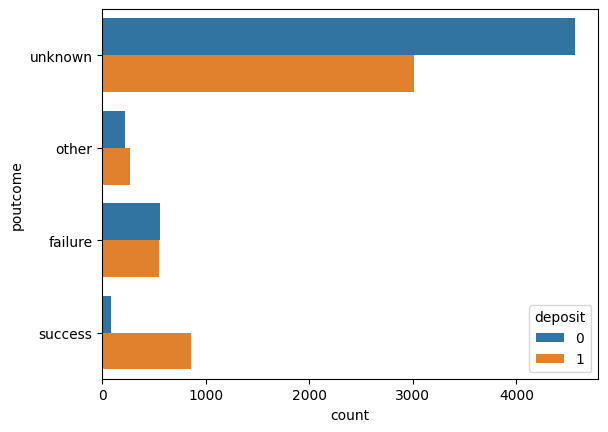

In [29]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
sns.countplot(data=cleaned, y='poutcome', hue='deposit');

In [30]:
cleaned.poutcome.unique()

array(['unknown', 'other', 'failure', 'success'], dtype=object)

<Axes: xlabel='poutcome'>

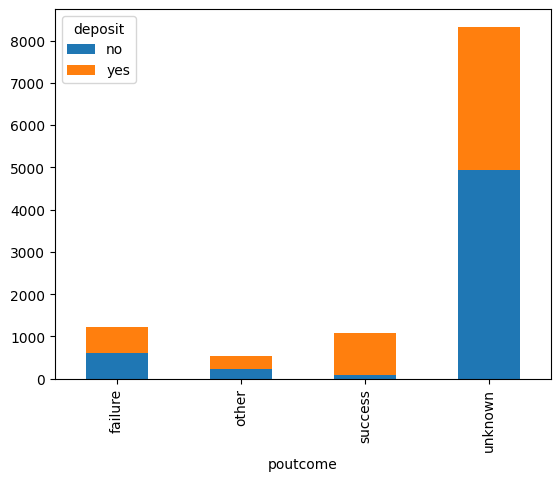

In [31]:
types = df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

>Как видим, люди, согласившиеся открыть депозит в предыдущей маркетинговой кампании скорее всего соглашаются и в текущей

### Задание 7

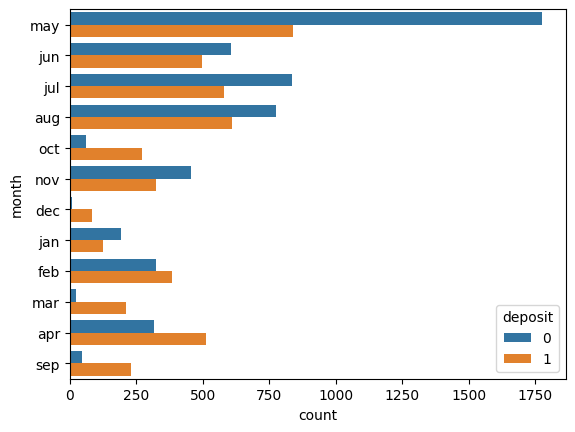

In [32]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
sns.countplot(data=cleaned, y='month', hue='deposit');

In [33]:
cleaned.month.unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

>В мае количество отказавшихся открыть депозит сильно выше количества согласившихся. Однако не стоит делать вывод, что в мае подобных акций лучше не проводить, поскольку в этот месяц общее количество обработанных заявок сильно выше, чем в другие месяцы, и количество согласившихся открыть депозит хоть и меньше в процентном соотношении количества отказавшихся, однако все равно количественно выше чем согласившиеся в другие месяцы

### Задание 8

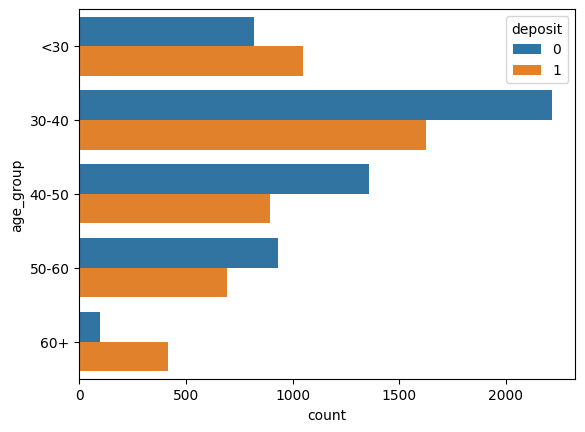

In [34]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
cleaned['age_group'] = pd.cut(cleaned.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])

sns.countplot(data=cleaned, y='age_group', hue='deposit');

### Задания 9 и 10

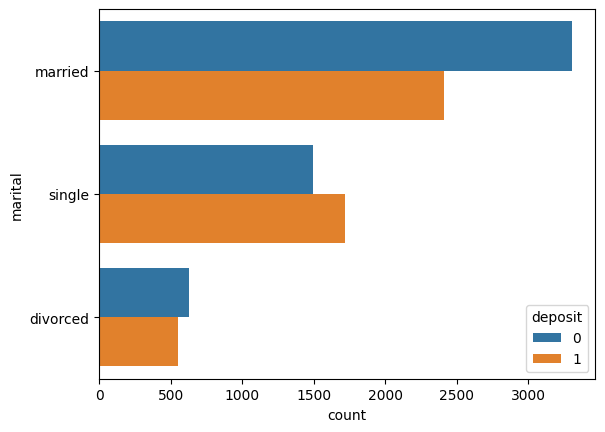

In [35]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(data=cleaned, y='marital', hue='deposit');

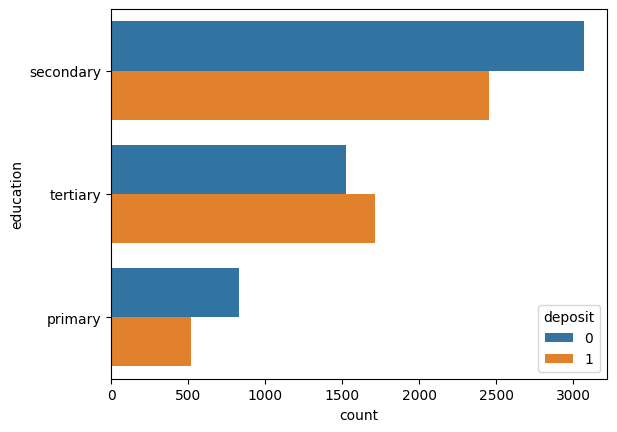

In [36]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(data=cleaned, y='education', hue='deposit');

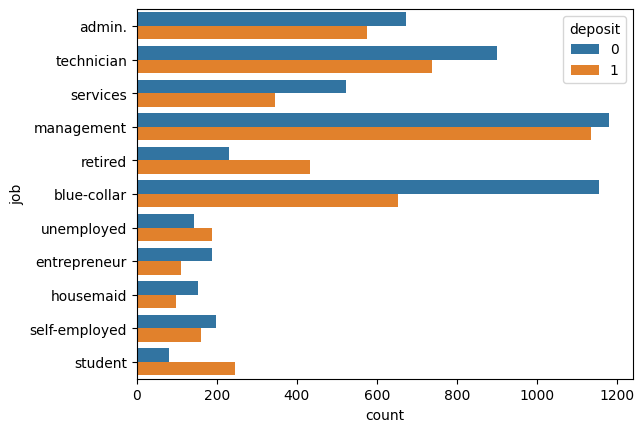

In [40]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.countplot(data=cleaned, y='job', hue='deposit');

### Задание 11

In [38]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
pd.crosstab(cleaned.deposit, [cleaned.education, cleaned.marital], rownames=["deposit"], 
            colnames=["education", "marital"])

education  primary                secondary                tertiary          \
marital   divorced married single  divorced married single divorced married   
deposit                                                                       
0               91     641    100       370    1830    866      163     832   
1               96     339     82       283    1289    879      174     784   

education         
marital   single  
deposit           
0            531  
1            755

In [41]:
deposit_tab = pd.crosstab(index = cleaned.education, columns = cleaned.marital, 
                          values = cleaned.deposit, aggfunc = 'sum')
deposit_tab

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


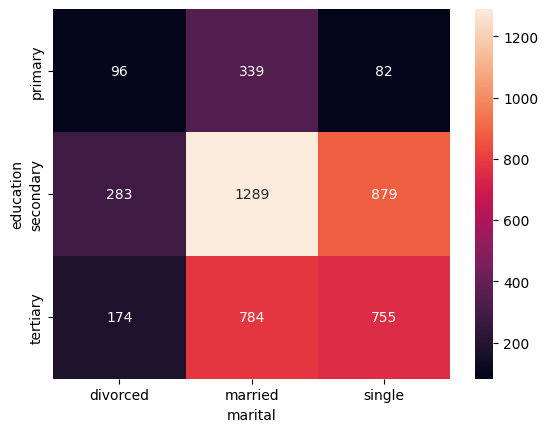

In [42]:
sns.heatmap(deposit_tab, annot=True, fmt=".0f");

## Часть 3: преобразование данных

### Задание 1

In [43]:
# преобразуйте уровни образования
# функция для кодирования,
def LabelEncoder_column(d_col):
    le = LabelEncoder()
    le.fit(data[[d_col]])
    return le.transform(data[[d_col]])

data = cleaned.copy()
data['education'] = LabelEncoder_column('education')
data['education'].sum()

11995

In [44]:
data['age_group'] = LabelEncoder_column('age_group')
data.sample(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
1983,33,admin.,single,1,no,315.0,yes,yes,cellular,14,may,888,3,-1,0,unknown,1,0
3574,60,unemployed,married,1,no,1047.0,no,no,cellular,27,may,173,3,279,4,success,1,2
3768,44,self-employed,divorced,1,no,8.0,no,no,cellular,26,jul,423,4,-1,0,unknown,1,1


### Задания 2 и 3

In [45]:
# преобразуйте бинарные переменные в представление из нулей и единиц
bin_cols = ['default', 'housing', 'loan']
for col in bin_cols:
    data[col] = data[col].apply(lambda x: 1 if x == 'yes' else 0)
    
data.sample(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
8915,43,services,married,1,0,43.0,1,0,cellular,18,may,199,1,-1,0,unknown,0,1
1176,33,blue-collar,married,1,0,315.0,0,0,cellular,4,feb,146,3,-1,0,unknown,1,0
6611,44,blue-collar,married,2,0,2185.0,1,0,unknown,16,may,698,1,-1,0,unknown,0,1


In [46]:
print(np.round(data.deposit.std(), 3))

0.499


Вычислим среднее арифметическое для каждой из получившихся переменных, сложим три результата и в качестве ответа получим итог, округлив его до трёх знаков после точки-разделителя.

In [47]:
np.round((data.default.mean()+data.housing.mean()+data.loan.mean()), 3)

0.635

In [48]:
data.contact.unique()

array(['unknown', 'cellular', 'telephone'], dtype=object)

### Задание 4

In [49]:
# создайте дамми-переменные
dummies_data = pd.get_dummies(data)
dummies_data.columns

Index(['age', 'education', 'default', 'balance', 'housing', 'loan', 'day',
       'duration', 'campaign', 'pdays', 'previous', 'deposit', 'age_group',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

### Задания 5 и 6

<Axes: >

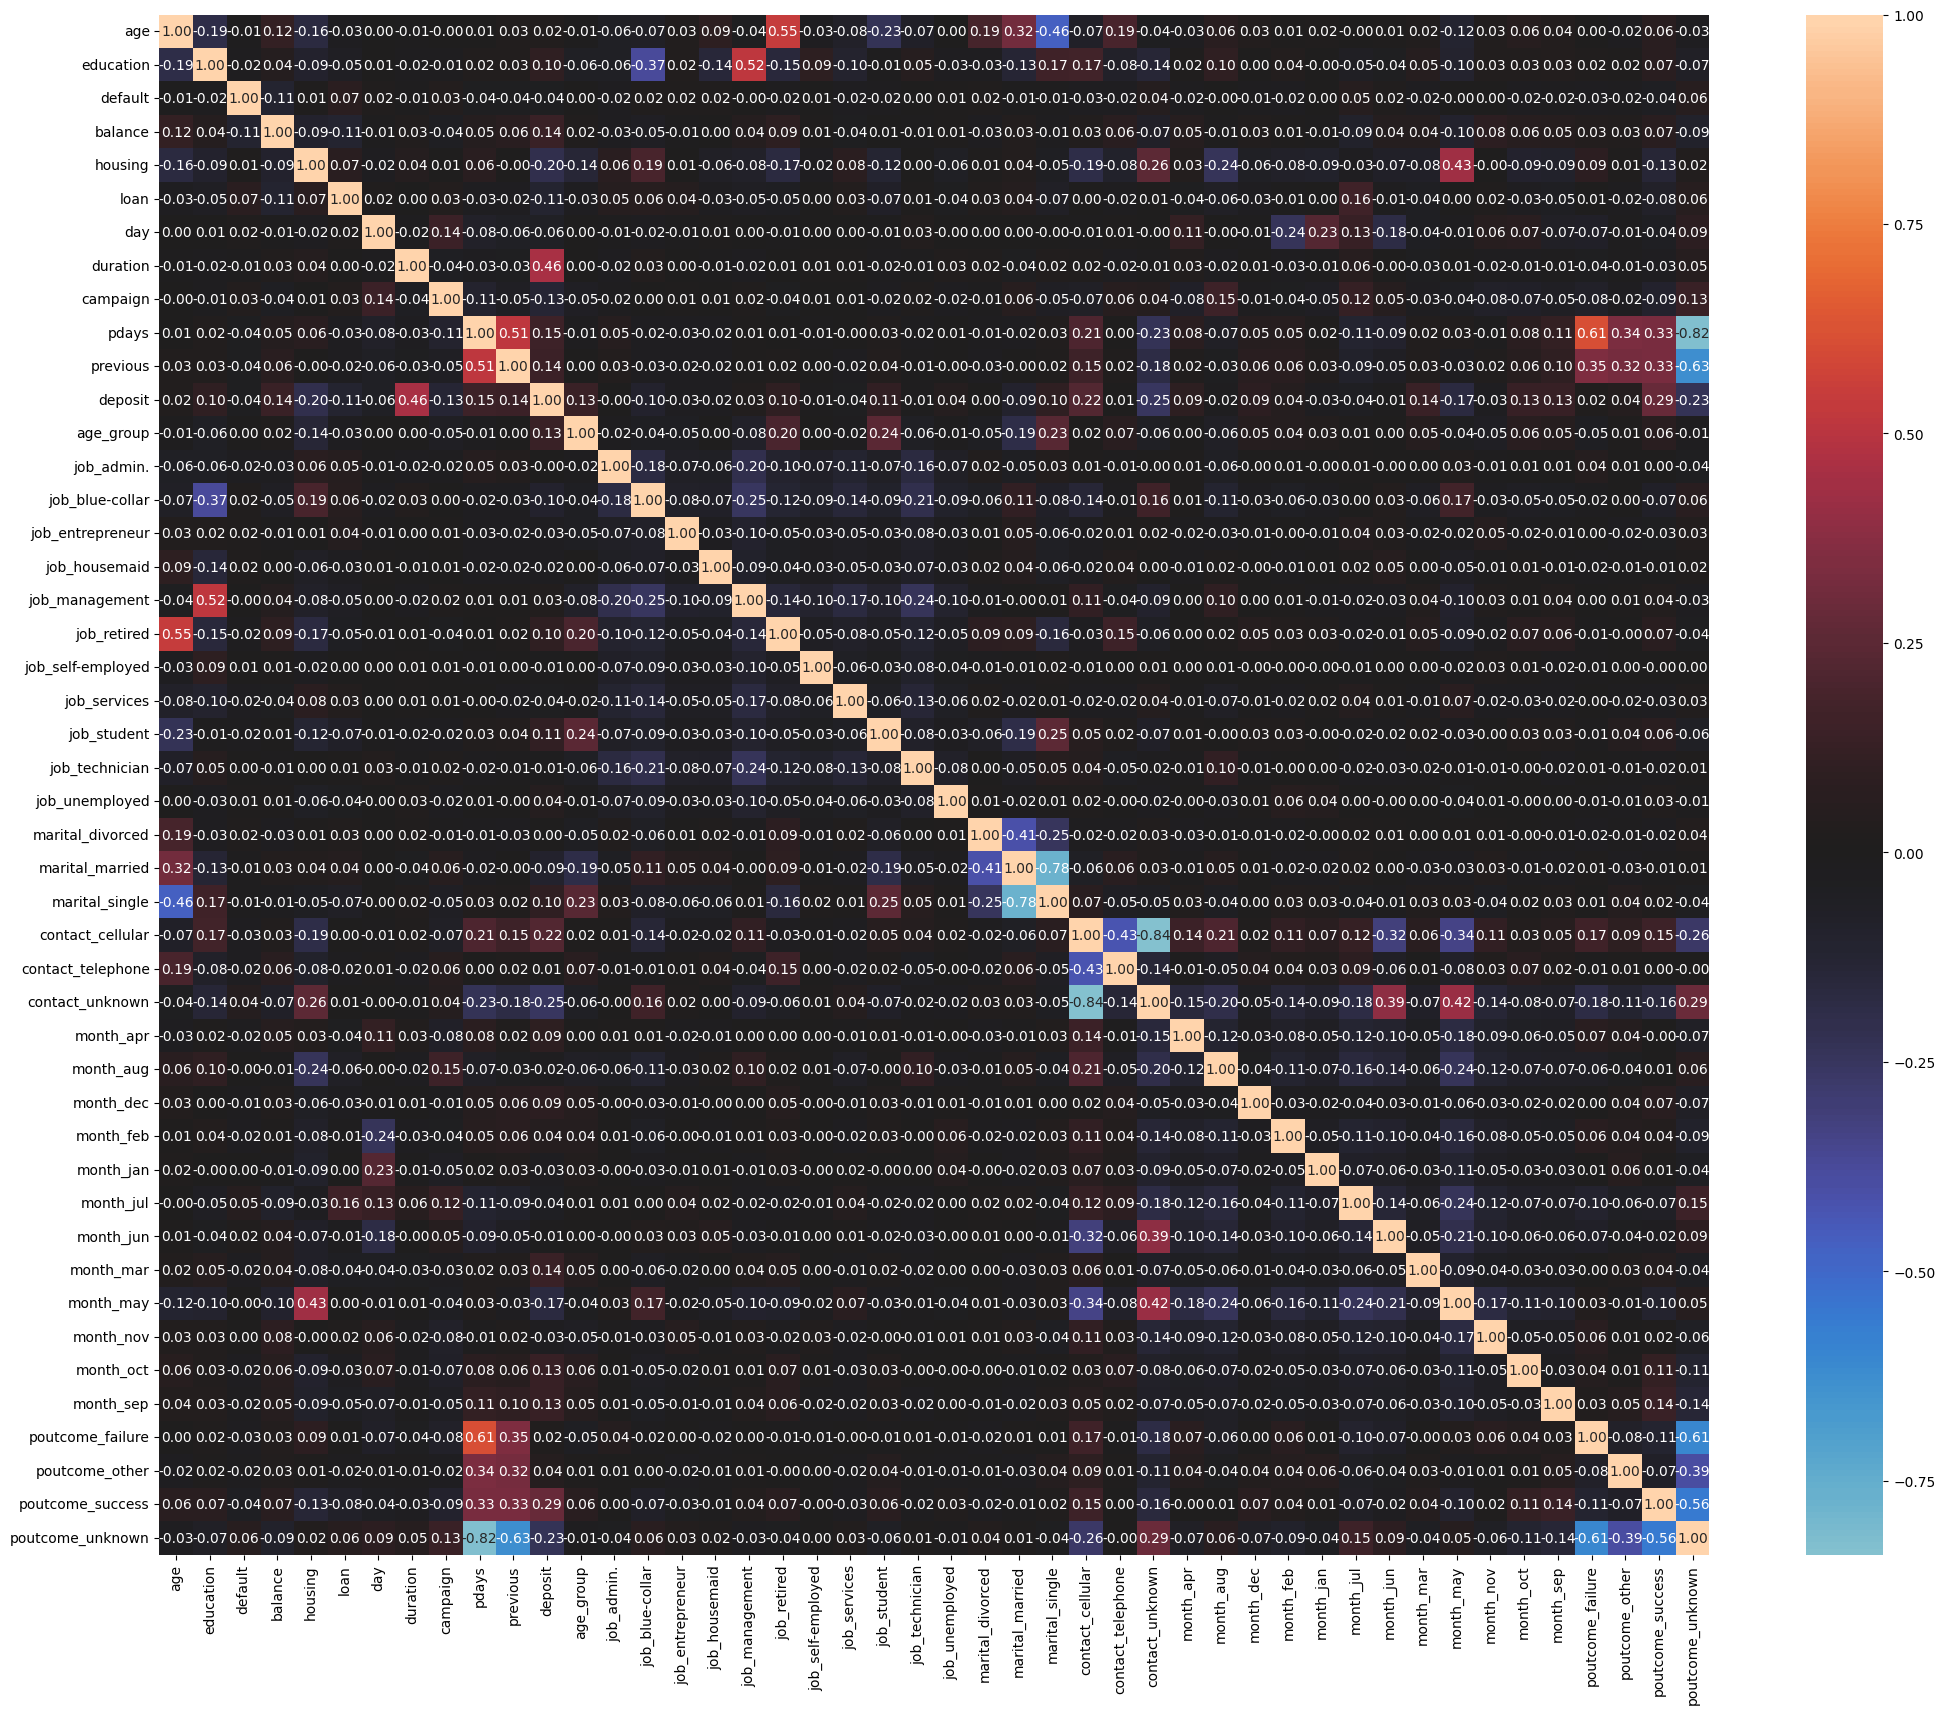

In [50]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(25,20))  
sns.heatmap(dummies_data.corr(),fmt='.2f',annot=True, center=0)

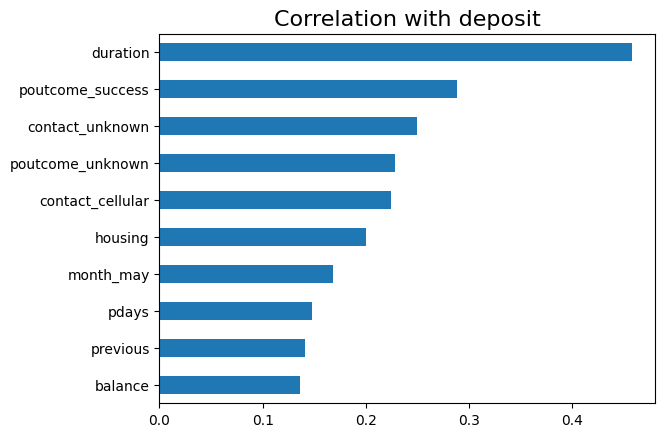

In [51]:
corr = dummies_data.corr()
corr["deposit"].apply(lambda x: abs(x)).sort_values()[-11:-1].plot.barh()
plt.title("Correlation with deposit", fontsize = 16)
plt.show()

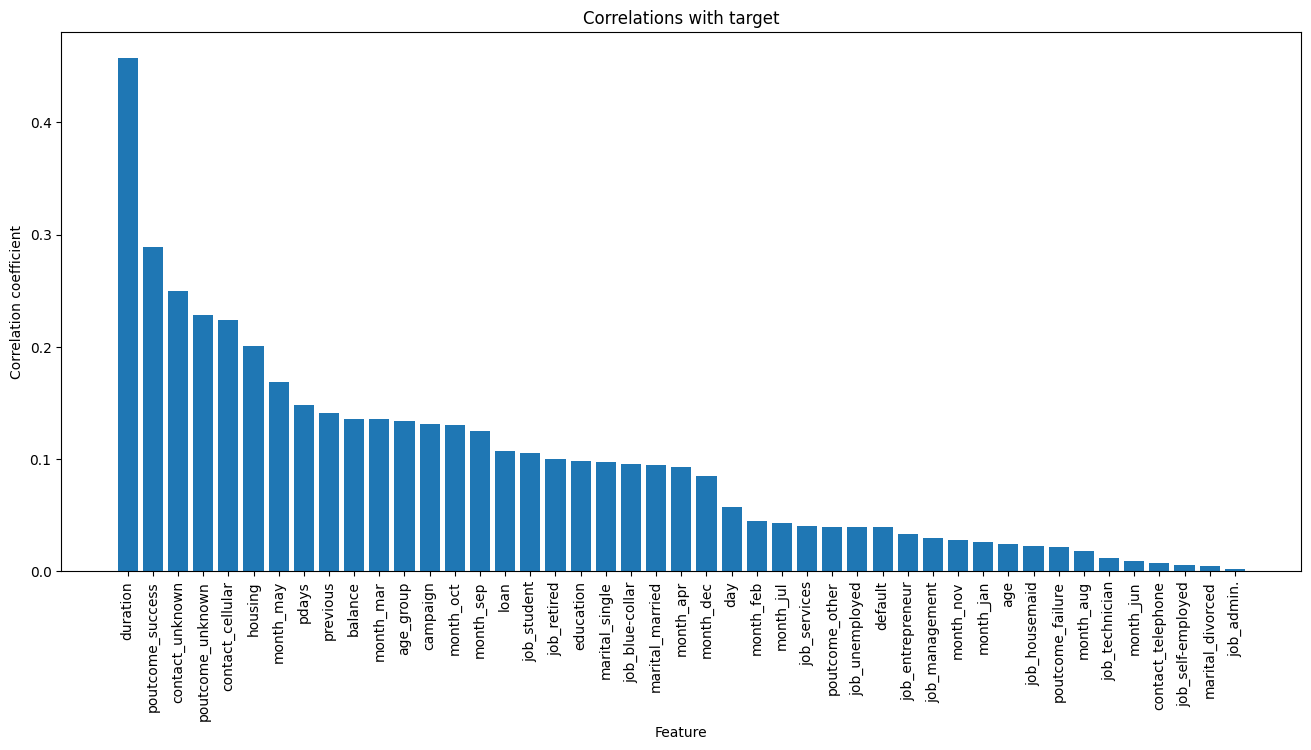

In [52]:
#Вычисляем модуль корреляции
corr_with_target = dummies_data.corr()['deposit'].abs().sort_values(ascending=False)
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('deposit')
#Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(16, 7)) #фигура+координатная плоскость
plt.xticks(rotation=90)
ax.bar(corr_with_target.index, corr_with_target.values) #столбчатая диаграмма
ax.set_title('Correlations with target') #название графика
ax.set_xlabel('Feature') #название оси x
ax.set_ylabel('Сorrelation coefficient'); #название оси y

### Задания 7 и 8

In [53]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [55]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [56]:
# рассчитайте необходимые показатели
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))
print(y_test.mean().round(2))

Train shape: (7478, 16)
Test shape: (3684, 16)


TypeError: Could not convert string 'nonoyesnoyesnonoyesnoyesyesnoyesnononoyesnonoyesnonononoyesyesnoyesyesnoyesyesyesyesnononononoyesnoyesnoyesnoyesnononoyesnonoyesnononoyesyesnoyesnonoyesyesyesnoyesyesnoyesnonononoyesyesyesnonononoyesnononoyesyesyesnoyesnoyesnoyesyesyesnonoyesyesyesyesnoyesyesyesyesnoyesyesyesyesyesyesyesyesyesnoyesyesyesyesnoyesyesnononononononoyesnonoyesyesyesnononoyesyesyesnoyesyesnoyesyesnoyesyesyesnonononoyesyesnonoyesyesyesnonoyesnononoyesnononoyesyesnonoyesyesyesyesyesyesyesnonoyesyesnoyesnoyesyesyesyesnonoyesyesnonoyesnonononoyesnonoyesnoyesnononononononoyesnoyesyesyesnonononoyesnonoyesnonoyesnonononoyesnonononoyesnoyesnonononoyesnoyesnoyesnoyesnoyesnoyesnoyesyesnononoyesnononononoyesyesnoyesnononoyesnoyesnononononoyesyesnoyesyesnonononoyesnonoyesyesyesnoyesnonoyesyesnoyesyesnoyesnonoyesyesnonononoyesnoyesnonoyesnoyesnonononoyesyesyesyesyesnononononoyesyesnoyesnoyesyesnoyesnoyesnonononoyesnonoyesyesyesyesyesnoyesnonoyesyesyesnonoyesyesyesyesnononoyesyesyesnonononoyesyesnononoyesyesyesyesnononoyesyesnonononoyesyesyesnononoyesyesyesyesnonononoyesnoyesnonoyesyesnonoyesyesnoyesyesyesyesyesnonoyesyesnonoyesyesyesnoyesyesyesyesnononononoyesnoyesyesnoyesnononoyesnoyesyesyesyesyesnonononoyesyesnononoyesnoyesnonoyesyesyesnoyesyesnoyesnononononoyesyesnoyesnonononononoyesnononoyesyesnononononoyesnononoyesyesyesnononoyesnonononononoyesnoyesnonoyesnoyesnoyesnonoyesnoyesnoyesnoyesnonoyesyesyesyesyesyesnoyesyesyesyesnoyesyesyesnonoyesnoyesnonoyesyesnoyesyesyesyesyesnonoyesnoyesyesnonoyesyesnoyesnoyesnononoyesyesyesnoyesyesyesyesnononononoyesyesyesnoyesnonononoyesyesnoyesyesyesnoyesnoyesnoyesyesnonononoyesyesyesyesyesnonoyesnononoyesnononoyesnononoyesnoyesyesyesnoyesyesyesnoyesyesyesyesnoyesnoyesnoyesyesnoyesyesnononoyesnononoyesyesyesnononononoyesnononononoyesyesnonononoyesnoyesyesyesyesyesyesyesyesnononononononoyesnonononoyesyesnonoyesnonononoyesnonononoyesyesnoyesyesnoyesnonoyesnonoyesyesyesyesnononononoyesyesnonoyesyesnoyesnoyesnonononoyesyesyesyesnonoyesnonoyesyesyesnonononoyesnonoyesnonoyesnonoyesnonoyesyesnoyesyesnonoyesnoyesnoyesyesnoyesnoyesyesnononoyesnonononoyesnoyesyesnonoyesnononononononoyesnoyesyesyesyesyesnononoyesnonoyesyesnononoyesyesnononononoyesyesyesyesnonoyesnoyesnoyesyesyesnononononononoyesnoyesnoyesyesyesyesyesnoyesnoyesnonononoyesyesyesyesnonoyesnonoyesyesnonoyesyesnononoyesnoyesnoyesnoyesnononoyesyesyesnoyesyesnonoyesnoyesyesnonononoyesnoyesnoyesnonononoyesnoyesnoyesyesyesyesnoyesyesyesnononoyesyesyesyesnonoyesnononoyesnoyesnoyesyesnoyesyesyesnonoyesyesyesnonononoyesyesnonoyesyesnoyesyesyesyesyesnoyesyesnonoyesnononoyesnoyesyesnoyesnononononononoyesyesyesyesyesyesnonoyesnoyesyesnonoyesnoyesnonoyesnononononoyesyesnonononoyesyesyesnoyesnoyesyesnoyesyesnonononoyesnoyesyesnonononononononoyesyesyesnononononoyesnonoyesnonononononoyesyesnoyesnonononononoyesyesyesyesnonononoyesnonononoyesyesyesyesnonoyesnonononoyesyesyesyesyesnonoyesyesyesnonoyesnoyesyesyesnoyesnoyesyesnonoyesnononoyesnonononoyesyesyesyesyesyesnonoyesnoyesyesnoyesyesyesyesyesyesnononoyesnoyesnoyesyesnoyesnoyesyesyesnonoyesnoyesnononoyesnoyesyesnonoyesnononoyesyesnoyesnononoyesyesyesnononononononoyesnoyesyesyesyesyesyesnonoyesnoyesyesnoyesnoyesnoyesyesnoyesyesnoyesyesnoyesyesnoyesnonoyesnoyesnononoyesyesyesnononoyesyesnononoyesyesyesnoyesnoyesyesnoyesnoyesnononoyesnononoyesnoyesnoyesyesnoyesnonononononoyesnoyesyesnoyesnononoyesnonoyesyesyesnoyesyesnoyesnonononoyesnoyesnoyesnonoyesyesyesyesyesnononoyesnoyesyesnonoyesyesnoyesnonoyesnoyesnoyesnoyesnonoyesyesyesnoyesnonoyesyesnoyesnononononoyesnononoyesnoyesnoyesnononoyesnoyesnoyesnonoyesnononononoyesnoyesyesyesnoyesnononoyesyesnoyesyesnoyesyesyesnonoyesnoyesnononoyesyesyesnoyesnononoyesnononoyesyesyesnononononononoyesnoyesyesnoyesyesyesyesnoyesnoyesnoyesnoyesnoyesyesyesyesyesyesyesyesyesnonoyesyesyesnonoyesnononoyesnoyesyesyesnonoyesnoyesyesyesyesnonoyesnononoyesnononoyesnoyesnoyesyesnonononononoyesyesnoyesnoyesyesnononoyesnonoyesyesnoyesyesnonoyesnoyesyesnononononoyesnononoyesnononononoyesnoyesyesyesnonoyesyesyesyesnoyesyesyesnoyesnonononoyesnoyesyesyesnonoyesyesnonononoyesyesnoyesnonoyesyesnononoyesnoyesyesyesnononoyesyesnonoyesyesnonoyesnoyesnoyesnoyesyesnonoyesnononononoyesyesyesyesyesnoyesyesnonononononononoyesyesnoyesnonoyesyesyesyesyesyesyesyesnoyesnonoyesnononoyesyesyesyesnoyesyesnononoyesnoyesnoyesnonoyesnoyesnoyesnonononoyesyesyesyesyesyesnonoyesnoyesnoyesnonoyesyesnoyesnoyesyesyesyesyesnononoyesnoyesyesnoyesnoyesnononoyesyesyesyesnoyesyesnonononoyesyesyesyesnonononoyesyesnonoyesnoyesnonoyesyesyesnoyesyesyesnoyesnononononoyesnonoyesnoyesnoyesyesyesnononoyesnoyesyesnoyesyesnonoyesnonononoyesnononononononoyesyesyesnoyesyesyesyesyesyesnonoyesyesnoyesnononoyesyesnonoyesnonononononononononoyesnonoyesyesyesnonoyesnononoyesyesyesnonoyesyesyesnononononononononoyesnonoyesnoyesnoyesyesyesyesnonoyesnonononoyesyesnoyesnoyesyesnoyesnoyesyesnonoyesyesyesyesyesnoyesyesnoyesyesnoyesyesnononoyesnonoyesyesnoyesnoyesyesnonoyesyesyesyesnoyesyesyesyesyesyesyesyesnoyesyesyesyesyesnononononoyesyesyesnoyesyesyesnoyesyesyesyesnonoyesyesyesnonoyesnoyesyesyesnoyesyesnonononoyesnononoyesyesyesyesyesyesnoyesyesnoyesyesyesnonoyesnonoyesyesyesyesyesnoyesyesnoyesnonononoyesnononononoyesyesyesnoyesyesyesnoyesnoyesnoyesyesnoyesyesnonononoyesnonoyesnoyesyesyesnoyesyesyesnononoyesnoyesnononoyesyesnononoyesyesnonoyesyesnonoyesyesnonoyesyesnoyesnononononoyesnoyesyesnoyesnoyesyesyesyesyesnonoyesyesnoyesyesyesyesnoyesyesnoyesyesnononoyesnonononoyesyesnononoyesyesnononoyesnoyesnononoyesyesnononoyesyesyesnononononononononoyesnonononoyesyesyesnononoyesyesnoyesyesnonononoyesyesnononoyesnoyesnonoyesyesyesnoyesyesyesnononoyesyesnononoyesyesyesnoyesnoyesnononoyesyesnonoyesyesnoyesnoyesyesyesnoyesyesyesnononoyesyesyesnoyesyesnononoyesyesnoyesnonononoyesnonoyesyesnonoyesnoyesyesnoyesyesyesnoyesyesyesyesnoyesnoyesnoyesyesyesyesnonoyesnoyesnoyesnoyesnoyesnononoyesnonoyesyesnoyesnonononoyesnoyesnoyesnoyesnoyesyesyesyesnonoyesyesyesnoyesyesyesyesnonoyesyesyesnonoyesnonoyesyesnoyesyesnononoyesnononoyesnonononoyesyesnoyesyesyesnononoyesnononoyesnonoyesnononononoyesnoyesnononononononoyesyesyesyesnononoyesnonoyesnonoyesnoyesyesyesnoyesnoyesnoyesyesyesyesnonoyesyesyesnoyesyesnonoyesyesnoyesnoyesyesyesyesnoyesyesnonoyesnoyesyesyesyesnoyesyesyesnonoyesyesnoyesnononononononononoyesnonoyesnononoyesnononononoyesnoyesyesyesyesnonoyesnoyesnoyesnononononoyesyesyesyesnonoyesnonoyesnoyesnonononononoyesnoyesyesyesyesnoyesnonoyesyesnoyesyesnoyesyesnoyesnononoyesnonoyesnonoyesnononoyesyesnoyesnonoyesyesyesyesnononoyesnononoyesnononoyesnoyesnoyesnoyesnoyesyesyesyesnonoyesyesnoyesyesyesnoyesnoyesnonoyesnoyesnonoyesyesyesyesyesnoyesyesnononoyesnoyesyesyesnoyesyesnoyesnonononoyesnonoyesyesnoyesnononoyesnonoyesyesyesnononoyesnononononoyesyesyesyesyesyesnoyesnoyesyesnonononoyesnoyesyesnonoyesnonoyesnonoyesyesnonononoyesyesnoyesyesnononoyesnonoyesyesyesnoyesyesnoyesnonoyesyesnonononoyesyesyesyesnononoyesnonoyesyesyesyesyesnoyesnoyesyesyesyesnonoyesnononoyesyesnoyesyesyesyesyesnononoyesnononoyesnononoyesnoyesyesnoyesyesyesyesnononoyesnoyesnoyesyesnoyesyesyesyesyesyesyesyesnoyesnoyesnoyesnoyesyesyesnonoyesnononoyesnonoyesnonoyesnonoyesnononoyesyesyesyesnoyesnonononononoyesnonoyesnoyesyesnonononoyesnonoyesyesnonononoyesyesyesnoyesnonoyesnonoyesyesyesnoyesnonoyesnoyesnoyesnoyesnoyesyesyesnoyesnonoyesyesyesyesnonoyesyesnonoyesnonoyesnononoyesyesnonoyesyesnonoyesyesyesyesnonoyesnoyesyesyesyesnonoyesnonoyesyesnonoyesnonoyesnoyesyesnoyesyesnonononoyesnononoyesyesyesyesyesnoyesyesyesnonoyesyesyesnonoyesyesnoyesyesnononoyesyesnonoyesyesnoyesnoyesnoyesyesnonononononononoyesyesyesyesyesyesnoyesyesyesyesnonoyesyesnonoyesyesnonoyesyesnonononoyesnoyesnoyesyesyesyesyesyesnoyesyesnoyesnonoyesyesnoyesyesnoyesyesnoyesyesnoyesnonoyesyesyesnonoyesnoyesyesnoyesyesyesnoyesyesnoyesyesyesnoyesnonoyesnonoyesyesnoyesnonoyesnoyesnonononoyesnoyesyesnoyesnonoyesnonoyesyesnoyesnoyesnoyesyesnononoyesnoyesyesnononoyesyesyesnonoyesnononononoyesyesyesyesyesnonononoyesnonoyesnonoyesyesnonononononoyesnonoyesnononoyesnonononononoyesnononoyesnononononoyesyesnoyesnonoyesyesyesnoyesnononoyesnoyesnoyesyesnoyesnoyesyesnoyesyesyesyesyesyesnoyesnonoyesyesnoyesyesyesnonoyesyesyesyesnonoyesnoyesnonoyesyesnoyesyesnonoyesnoyesyesnonoyesnonononoyesnononononoyesyesnoyesnonoyesnonononoyesyesnoyesyesnonoyesnoyesyesyesnonoyesnonoyesyesnonoyesnoyesnonononoyesyesnonononoyesyesyesyesyesyesnoyesnoyesyesnonoyesyesnonoyesyesyesyesnononononoyesyesnononoyesnoyesnononononoyesyesnoyesnoyesyesyesnononoyesnonoyesyesnonononononoyesnononoyesyesyesnononoyesnonoyesnoyesyesnoyesyesnononoyesnonoyesnoyesnononoyesyesyesnoyesnoyesyesyesyesnoyesyesyesnonoyesyesyesyesnoyesnonononoyesnoyesyesnoyesyesnoyesyesnoyesnoyesnoyesyesyesnonoyesyesnonoyesnononononononoyesnoyesnoyesnoyesnoyesyesyesnononoyesnoyesyesyesyesnoyesnononononoyesnonoyesnonoyesnoyesnonoyesnoyesnonoyesnonononoyesnononononoyesnononoyesyesnonononononoyesyesnononononoyesnoyesnoyesyesyesnononononononoyesnoyesnoyesyesyesnoyesnonoyesyesnonoyesnoyesnonoyesnoyesnonononoyesyesyesnononoyesyesnoyesyesnonoyesyesyesyesnoyesyesyesnoyesnononoyesnononoyesyesnonoyesnoyesnoyesyesyesnonoyesyesnonononoyesnoyesnoyesyesyesnonoyesnoyesnono' to numeric

### Задание 9

In [57]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

selector_col = list(selector.get_feature_names_out())
selector_col

ValueError: could not convert string to float: 'technician'

### Задание 10

In [ ]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [5]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)

#Делаем предсказание для тестовой выборки
y_test_pred = rf.predict(X_test_scaled)
#Вывод отчет о метриках классификации

NameError: name 'X_train_scaled' is not defined

### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna